In [3]:
### Test data ###
import sys
sys.path.insert(0, '../')

import CRISPR_functions
from CRISPR_functions import find_optimum_rho_and_distances_ordered_model,phylogeny_from_CRISPR

arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[13,14]]

final_dist,rho=find_optimum_rho_and_distances_ordered_model(arrays)


iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...


In [47]:
print(final_dist)

{<CRISPR_functions.CRISPR_pair object at 0x7fa1debaad30>: (1.961298119967464, 2.567482947542273), <CRISPR_functions.CRISPR_pair object at 0x7fa1de3ff748>: (2.7761445856511497, 2.2691627856749466), <CRISPR_functions.CRISPR_pair object at 0x7fa1de3ff828>: (6.0502557260284515, 0.0)}


          0         1         2         3
0       NaN  1.961298       NaN       NaN
1  2.567483       NaN  2.776145       NaN
2       NaN  2.269163       NaN  6.050256
3       NaN       NaN  0.000000       NaN
          0         1         2         3         4
0       NaN  1.961298       NaN       NaN  0.980649
1  2.567483       NaN  2.776145       NaN  2.776145
2       NaN  2.269163       NaN  6.050256  2.269163
3       NaN       NaN  0.000000       NaN  0.000000
4 -0.104331  0.000000  0.000000  1.890546       NaN
clade1.branch_length 2.7761445856511497
clade2.branch_length 2.2691627856749466


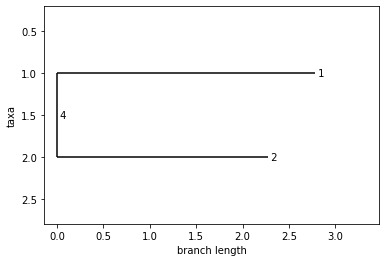

          0         3         4         5
0       NaN       NaN  0.980649  0.980649
3       NaN       NaN  0.000000  0.000000
4 -0.104331  1.890546       NaN -0.104331
5  0.000000  0.997439  0.000000       NaN
clade1.branch_length 0.980649059983732
clade2.branch_length -0.1043308190544383


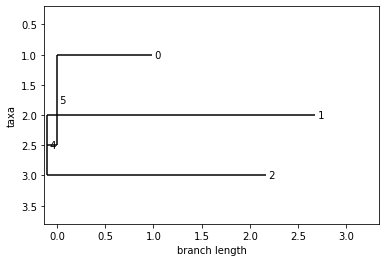

          3    5         6
3       NaN  0.0  0.000000
5  0.997439  NaN  0.997439
6  0.000000  0.0       NaN
clade1.branch_length 0.0
clade2.branch_length 0.9974386446155954


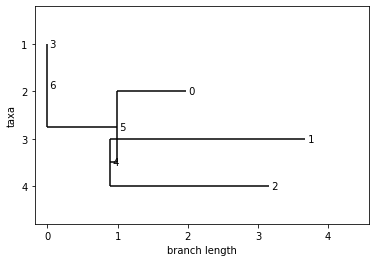

{0: '9-2-3-4-5', 1: '0-1-2-3-7-8', 2: '1-10-11-12-13', 3: '13-14', '9-2-3-4-5': 0, '0-1-2-3-7-8': 1, '1-10-11-12-13': 2, '13-14': 3}


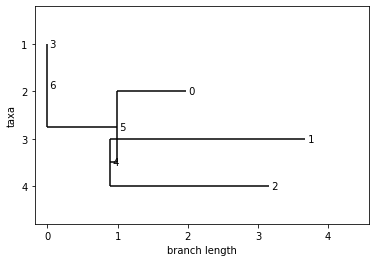

total branch length of the tree 6.9190642568709855


,0,1,2,3
0,NaN,3.65246,3.14548,1.97809
1,3.65246,NaN,5.04531,3.66925
2,3.14548,5.04531,NaN,3.16227
3,1.97809,3.66925,3.16227,NaN


In [20]:
from CRISPR_functions import get_weights_for_all_pairs,get_new_node_distance,get_distance_matrix_from_phylogeny
from Bio.Phylo import BaseTree,draw_ascii
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade,Tree

import pandas as pd
import numpy as np
def phylogeny_from_CRISPR(arrays,final_dist):
    '''Given a list of CRISPR arrays and a dictionnary of optimized distances, returns a phylogenetic tree (Tree class) of the CRISPR arrays and a dictionary of labels'''
    names=[i for i in range(len(arrays))]
    seqs=['-'.join(map(str,arr)) for arr in arrays]

    dic=dict(zip(names+seqs,seqs+names))
    dic
    df=pd.DataFrame(np.nan,columns=names,index=names)

    for k,v in final_dist.items():
        x=dic['-'.join(map(str,k.s1))] #row "distance from common ancestor to x..."
        y=dic['-'.join(map(str,k.s2))] # column "...when associated to y"
        d_xy=v[0]
        d_yx=v[1]

        df.loc[x,y]=d_xy
        df.loc[y,x]=d_yx
    print(df)
    # init terminal clades 
    clades = dict(zip(df.index,(BaseTree.Clade(None, str(name)) for name in df.index)))
    inner_count = len(df)-1

    while len(df.columns)>1:
        inner_count+=1

        # find minimum distance pair
        max_pair=get_weights_for_all_pairs(df)
        min_i=max_pair[0]
        min_j=max_pair[1]

        # calculate nodeDist
        df=get_new_node_distance(df,max_pair)
        print(df)
        # create clade 
        clade1 = clades[min_i] 
        clade2 = clades[min_j] 
        inner_clade = BaseTree.Clade(None, str(inner_count)) 
        inner_clade.clades.append(clade1) 
        inner_clade.clades.append(clade2) 
        # assign branch length 
        clade1.branch_length = float(df.loc[min_i, min_j])
        clade2.branch_length = float(df.loc[min_j, min_i])
#         # correct branch length to 0 if negative
#         clade1.branch_length = 0 if clade1.branch_length<0 else clade1.branch_length
#         clade2.branch_length = 0 if clade2.branch_length<0 else clade2.branch_length
        print('clade1.branch_length',clade1.branch_length)
        print('clade2.branch_length',clade2.branch_length)

        # update node dict 
        clades[inner_count] = inner_clade
        Phylo.draw(Tree(inner_clade))
        del clades[min_i]
        del clades[min_j]
        if len(clades)==1:
            inner_clade.branch_length = None

        # rebuild distance matrix
        df=df.drop([min_i,min_j],axis=1).drop([min_i,min_j],axis=0)

    TREE=Tree(inner_clade,rooted=True)
    return(TREE,dic)

##################

thetree,labels=phylogeny_from_CRISPR(arrays,final_dist)
print(labels)

# draw_ascii(Tree)
# Tree.rooted=False
Phylo.draw(thetree)
print('total branch length of the tree',thetree.total_branch_length())
get_distance_matrix_from_phylogeny(thetree)

          0         1         2         3
0       NaN  1.961298       NaN       NaN
1  2.567483       NaN  2.776145       NaN
2       NaN  2.269163       NaN  6.050256
3       NaN       NaN  0.000000       NaN
          0         1         2         3         4
0       NaN  1.961298       NaN       NaN  0.980649
1  2.567483       NaN  2.776145       NaN  2.776145
2       NaN  2.269163       NaN  6.050256  2.269163
3       NaN       NaN  0.000000       NaN  0.000000
4 -0.104331  0.000000  0.000000  1.890546       NaN
clade1.branch_length 2.7761445856511497
clade2.branch_length 2.2691627856749466


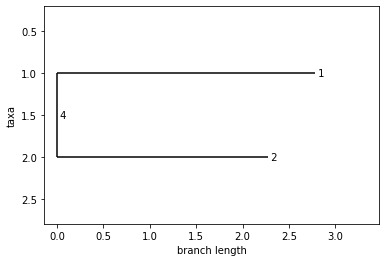

          0         3         4         5
0       NaN       NaN  0.980649  0.980649
3       NaN       NaN  0.000000  0.000000
4 -0.104331  1.890546       NaN -0.104331
5  0.000000  0.997439  0.000000       NaN
clade1.branch_length 0.980649059983732
clade2.branch_length 0


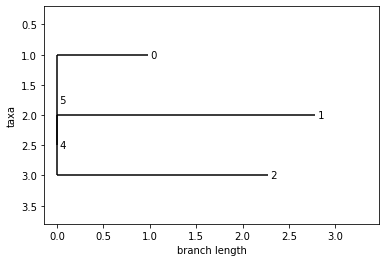

          3    5         6
3       NaN  0.0  0.000000
5  0.997439  NaN  0.997439
6  0.000000  0.0       NaN
clade1.branch_length 0.0
clade2.branch_length 0.9974386446155954


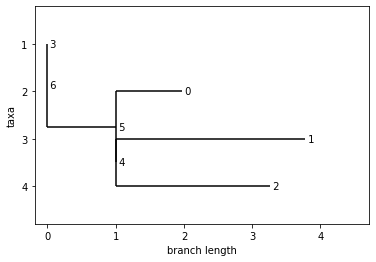

{0: '9-2-3-4-5', 1: '0-1-2-3-7-8', 2: '1-10-11-12-13', 3: '13-14', '9-2-3-4-5': 0, '0-1-2-3-7-8': 1, '1-10-11-12-13': 2, '13-14': 3}


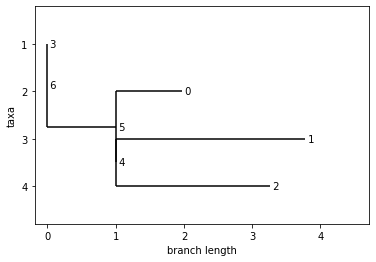

total branch length of the tree 7.023395075925423


,0,1,2,3
0,NaN,3.75679,3.24981,1.97809
1,3.75679,NaN,5.04531,3.77358
2,3.24981,5.04531,NaN,3.2666
3,1.97809,3.77358,3.2666,NaN


In [21]:
from CRISPR_functions import get_weights_for_all_pairs,get_new_node_distance,get_distance_matrix_from_phylogeny
from Bio.Phylo import BaseTree,draw_ascii
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade,Tree

import pandas as pd
import numpy as np
def phylogeny_from_CRISPR_noneg(arrays,final_dist):
    '''Given a list of CRISPR arrays and a dictionnary of optimized distances, returns a phylogenetic tree (Tree class) of the CRISPR arrays and a dictionary of labels'''
    names=[i for i in range(len(arrays))]
    seqs=['-'.join(map(str,arr)) for arr in arrays]

    dic=dict(zip(names+seqs,seqs+names))
    dic
    df=pd.DataFrame(np.nan,columns=names,index=names)

    for k,v in final_dist.items():
        x=dic['-'.join(map(str,k.s1))] #row "distance from common ancestor to x..."
        y=dic['-'.join(map(str,k.s2))] # column "...when associated to y"
        d_xy=v[0]
        d_yx=v[1]

        df.loc[x,y]=d_xy
        df.loc[y,x]=d_yx
    print(df)
    # init terminal clades 
    clades = dict(zip(df.index,(BaseTree.Clade(None, str(name)) for name in df.index)))
    inner_count = len(df)-1

    while len(df.columns)>1:
        inner_count+=1

        # find minimum distance pair
        max_pair=get_weights_for_all_pairs(df)
        min_i=max_pair[0]
        min_j=max_pair[1]

        # calculate nodeDist
        df=get_new_node_distance(df,max_pair)
        print(df)
        # create clade 
        clade1 = clades[min_i] 
        clade2 = clades[min_j] 
        inner_clade = BaseTree.Clade(None, str(inner_count)) 
        inner_clade.clades.append(clade1) 
        inner_clade.clades.append(clade2) 
        # assign branch length 
        clade1.branch_length = float(df.loc[min_i, min_j])
        clade2.branch_length = float(df.loc[min_j, min_i])
#         # correct branch length to 0 if negative
        clade1.branch_length = 0 if clade1.branch_length<0 else clade1.branch_length
        clade2.branch_length = 0 if clade2.branch_length<0 else clade2.branch_length
        print('clade1.branch_length',clade1.branch_length)
        print('clade2.branch_length',clade2.branch_length)

        # update node dict 
        clades[inner_count] = inner_clade
        Phylo.draw(Tree(inner_clade))
        del clades[min_i]
        del clades[min_j]
        if len(clades)==1:
            inner_clade.branch_length = None

        # rebuild distance matrix
        df=df.drop([min_i,min_j],axis=1).drop([min_i,min_j],axis=0)

    TREE=Tree(inner_clade,rooted=True)
    return(TREE,dic)

##################

thetree,labels=phylogeny_from_CRISPR_noneg(arrays,final_dist)
print(labels)

# draw_ascii(Tree)
# Tree.rooted=False
Phylo.draw(thetree)
print('total branch length of the tree',thetree.total_branch_length())
get_distance_matrix_from_phylogeny(thetree)

In [ ]:
from Bio import Phylo
from CRISPR_functions import phylogeny_from_CRISPR,get_distance_matrix_from_phylogeny

arrays=
final_dist = 


Tree,labels=phylogeny_from_CRISPR(arrays,final_dist)
print(labels)
Phylo.draw(Tree)
Tree_unrooted=Tree
Tree_unrooted.rooted=False

dist=get_distance_matrix_from_phylogeny(Tree_unrooted)

In [19]:
### removes the negative branches but does not report their values to the adjacent branch

# from Bio import Phylo
import ete3

with open('../Mydata/Runs_on_cluster/run2/arrays_in_whole_dataset_v6.nwk','r') as f:
    lines=f.read().splitlines()
#     print(lines)
tree = ete3.Tree(lines[0])
print(tree)

    
for clade in tree.traverse():
#     print(clade.branch_length)
    clade.dist = 0 if clade.dist<0 else clade.dist
# taxa=sorted(map(int,[cl.name for cl in Tree.get_terminals()]))
# matrix=pd.DataFrame([],columns=taxa,index=taxa)
# for combi in itertools.combinations(range(len(taxa)),2):
#     tgt1=str(combi[0])
#     tgt2=str(combi[1])
#     dist=Tree.distance({"name": tgt1}, {"name": tgt2})
#     trace=Tree.trace({"name": tgt1}, {"name": tgt2})
#     print(trace)
# matrix
# print(tree)
Phylo.draw(tree)
# tree.write(outfile='./Runs_on_cluster/run2/arrays_in_whole_dataset_v6_noneg.tmp')


   /-11
  |
  |         /-14
  |      /-|
  |     |  |   /-122
  |     |   \-|
  |     |     |   /-15
  |     |      \-|
  |     |         \-16
  |     |
  |     |      /-62
  |     |   /-|
  |     |  |  |   /-26
  |     |  |   \-|
  |     |  |      \-27
  |     |  |
  |     |  |      /-10
  |     |  |     |
  |     |  |     |      /-112
  |     |  |     |   /-|
  |     |  |     |  |  |   /-95
  |     |  |     |  |   \-|
  |     |  |   /-|  |     |   /-109
  |     |  |  |  |  |      \-|
  |     |  |  |  |  |         \-110
  |     |  |  |  |  |
  |     |  |  |  |  |   /-57
  |     |  |  |  |  |  |
  |     |  |  |   \-|  |      /-56
  |     |  |  |     |  |   /-|
  |     |  |  |     |  |  |  |   /-36
  |     |  |  |     |  |  |   \-|
  |   /-|  |  |     |  |  |     |   /-37
  |  |  |  |  |     |  |  |      \-|
  |  |  |  |  |     |  |  |         \-38
  |  |  |  |  |     |  |  |
  |  |  |  |  |     |  |  |         /-117
  |  |  |  |  |     |  |  |      /-|
  |  |  |  |  |      \-|  |    

AttributeError: 'TreeNode' object has no attribute 'get_terminals'

In [144]:

Trees = [tree for tree in Phylo.parse('./Runs_on_cluster/run2/arrays_in_whole_dataset_v6_noneg.tmp', 'newick')]
tree = Trees[0]
Phylo.draw(tree)
df=get_distance_matrix_from_phylogeny(tree)
df.to_csv('./Runs_on_cluster/run2/arrays_in_whole_dataset_v6_noneg_pairwiseDist.csv',header=True,sep='\t')
df

FileNotFoundError: [Errno 2] No such file or directory: './Runs_on_cluster/run2/arrays_in_whole_dataset_v6_noneg.tmp'

          0         1         2         3
0       NaN  1.961298       NaN       NaN
1  2.567483       NaN  2.776145       NaN
2       NaN  2.269163       NaN  6.050256
3       NaN       NaN  0.000000       NaN
          0         1         2         3         4
0       NaN  1.961298       NaN       NaN  0.980649
1  2.567483       NaN  2.776145       NaN  2.776145
2       NaN  2.269163       NaN  6.050256  2.269163
3       NaN       NaN  0.000000       NaN  0.000000
4 -0.104331  0.000000  0.000000  1.890546       NaN
clade1 1
clade2 2
clade1.branch_length 2.7761445856511497
clade2.branch_length 2.2691627856749466
clade1.branch_length 2.7761445856511497
clade2.branch_length 2.2691627856749466


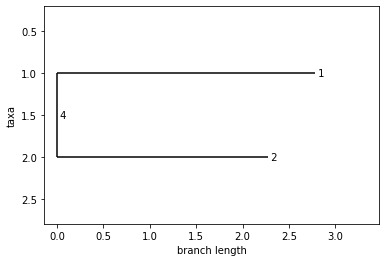

          0         3         4         5
0       NaN       NaN  0.980649  0.980649
3       NaN       NaN  0.000000  0.000000
4 -0.104331  1.890546       NaN -0.104331
5  0.000000  0.997439  0.000000       NaN
clade1 0
clade2 4
clade1.branch_length 0.980649059983732
clade2.branch_length -0.1043308190544383
clade1.branch_length 0.8763182409292937
clade2.branch_length 0


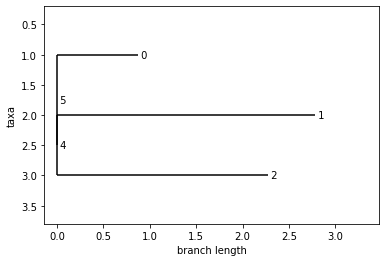

          3    5         6
3       NaN  0.0  0.000000
5  0.997439  NaN  0.997439
6  0.000000  0.0       NaN
clade1 3
clade2 5
clade1.branch_length 0.0
clade2.branch_length 0.9974386446155954
clade1.branch_length 0.0
clade2.branch_length 0.9974386446155954


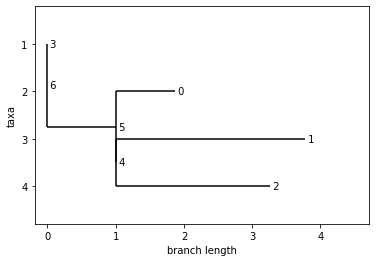

{0: '9-2-3-4-5', 1: '0-1-2-3-7-8', 2: '1-10-11-12-13', 3: '13-14', '9-2-3-4-5': 0, '0-1-2-3-7-8': 1, '1-10-11-12-13': 2, '13-14': 3}


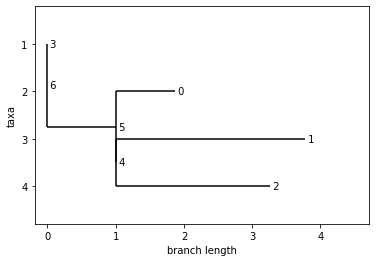

total branch length of the tree 6.9190642568709855


,0,1,2,3
0,NaN,3.65246,3.14548,1.87376
1,3.65246,NaN,5.04531,3.77358
2,3.14548,5.04531,NaN,3.2666
3,1.87376,3.77358,3.2666,NaN


In [145]:
from CRISPR_functions import get_weights_for_all_pairs,get_new_node_distance,get_distance_matrix_from_phylogeny
from Bio.Phylo import BaseTree,draw_ascii
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade,Tree

import pandas as pd
import numpy as np
def phylogeny_from_CRISPR_noneg(arrays,final_dist):
    '''Given a list of CRISPR arrays and a dictionnary of optimized distances, returns a phylogenetic tree (Tree class) of the CRISPR arrays and a dictionary of labels'''
    names=[i for i in range(len(arrays))]
    seqs=['-'.join(map(str,arr)) for arr in arrays]

    dic=dict(zip(names+seqs,seqs+names))
    dic
    df=pd.DataFrame(np.nan,columns=names,index=names)

    for k,v in final_dist.items():
        x=dic['-'.join(map(str,k.s1))] #row "distance from common ancestor to x..."
        y=dic['-'.join(map(str,k.s2))] # column "...when associated to y"
        d_xy=v[0]
        d_yx=v[1]

        df.loc[x,y]=d_xy
        df.loc[y,x]=d_yx
    print(df)
    # init terminal clades 
    clades = dict(zip(df.index,(BaseTree.Clade(None, str(name)) for name in df.index)))
    inner_count = len(df)-1

    while len(df.columns)>1:
        inner_count+=1

        # find minimum distance pair
        max_pair=get_weights_for_all_pairs(df)
        min_i=max_pair[0]
        min_j=max_pair[1]

        # calculate nodeDist
        df=get_new_node_distance(df,max_pair)
        print(df)
        # create clade 
        clade1 = clades[min_i] 
        clade2 = clades[min_j] 
        inner_clade = BaseTree.Clade(None, str(inner_count)) 
        inner_clade.clades.append(clade1) 
        inner_clade.clades.append(clade2) 
        # assign branch length 
        clade1.branch_length = float(df.loc[min_i, min_j])
        clade2.branch_length = float(df.loc[min_j, min_i])
#         # correct branch length to 0 if negative and transfer the difference to the adjacent branch length (Kuhner and Felsenstein, 1994)
        print('clade1',clade1)
        print('clade2',clade2)
        print('clade1.branch_length',clade1.branch_length)
        print('clade2.branch_length',clade2.branch_length)
        if clade1.branch_length<0:
            clade2.branch_length = clade2.branch_length+clade1.branch_length
            clade1.branch_length = 0
        if clade2.branch_length<0:
            clade1.branch_length = clade1.branch_length+clade2.branch_length
            clade2.branch_length = 0
#             print('clade1.branch_length after del',clade1.branch_length)

            
#         clade1.branch_length = 0 if clade1.branch_length<0 else clade1.branch_length
#         clade2.branch_length = 0 if clade2.branch_length<0 else clade2.branch_length
        print('clade1.branch_length',clade1.branch_length)
        print('clade2.branch_length',clade2.branch_length)

        # update node dict 
        clades[inner_count] = inner_clade
        Phylo.draw(Tree(inner_clade))
        del clades[min_i]
        del clades[min_j]
        if len(clades)==1:
            inner_clade.branch_length = None

        # rebuild distance matrix
        df=df.drop([min_i,min_j],axis=1).drop([min_i,min_j],axis=0)

    TREE=Tree(inner_clade,rooted=True)
    return(TREE,dic)

##################
import ete3

with open('../Mydata/Runs_on_cluster/run2/arrays_in_whole_dataset_v6.nwk','r') as f:
    lines=f.read().splitlines()
#     print(lines)
tree = ete3.Tree(lines[0])
print(tree)

# draw_ascii(Tree)
# Tree.rooted=False
Phylo.draw(thetree)
print('total branch length of the tree',thetree.total_branch_length())
get_distance_matrix_from_phylogeny(thetree)

In [5]:
import CRISPR_functions
import pandas as pd
from CRISPR_functions import get_weights_for_all_pairs,get_new_node_distance,get_distance_matrix_from_phylogeny
from Bio.Phylo import BaseTree,draw_ascii
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade,Tree
# with open('/Users/maeperez/Desktop/CRISPR_distance/Mydata/arrays_in_whole_dataset_v6.txt') as f:
with open('/Users/maeperez/Desktop/CRISPR_distance/Mydata/arrays_in_whole_dataset_v6.2.txt') as f:

    lines=f.read().splitlines()
    arrays=[list(map(str,list(map(int,l.split(','))))) for l in lines]
print(len(arrays))

print(arrays)                
# df=pd.read_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run2/arrays_in_whole_dataset_v6_ancestorsDist.csv',sep='\t',index_col=0)
df=pd.read_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_ancestorsDist.csv',sep='\t',index_col=0)

df.columns=list(map(int,df.columns))
df.index=list(map(int,df.columns))
type(df.iloc[1,2])
print(df.columns)
clades = dict(zip(df.index,(BaseTree.Clade(None, str(name)) for name in df.index)))
# max_pair=get_weights_for_all_pairs(df)


124
[['5', '170', '51', '22', '79', '161', '174', '179', '37', '47', '440', '184', '55', '58', '295', '999'], ['5', '170', '51', '22', '79', '161', '174', '179', '440', '184', '55', '58', '295', '999'], ['5', '170', '161', '174', '179', '37', '47', '440', '184', '55', '58', '295', '999'], ['5', '170', '161', '174', '179', '37', '440', '184', '55', '58', '295', '999'], ['5', '170', '161', '174', '179', '37', '47', '184', '55', '58', '295', '999'], ['5', '170', '161', '174', '179', '37', '47', '440', '184', '58', '295', '999'], ['5', '170', '174', '179', '37', '47', '440', '184', '55', '295', '999'], ['5', '170', '161', '174', '179', '37', '47', '440', '184', '55', '295', '999'], ['5', '170', '161', '174', '179', '47', '440', '184', '55', '295', '999'], ['5', '170', '161', '184', '55', '295', '999'], ['999'], ['295', '999'], ['58', '295', '999'], ['55', '295', '999'], ['55', '58', '295', '999'], ['184', '58', '295', '999'], ['184', '55', '295', '999'], ['184', '55', '58', '295', '999'], 

In [6]:


# init terminal clades 
clades = dict(zip(df.index,(BaseTree.Clade(None, str(name)) for name in df.index)))
inner_count = len(df)-1

while len(df.columns)>1:
    inner_count+=1

    # find minimum distance pair
    max_pair=get_weights_for_all_pairs(df)
    min_i=max_pair[0]
    min_j=max_pair[1]

    # calculate nodeDist
    df=get_new_node_distance(df,max_pair)
#         print(df)
    # create clade 
    clade1 = clades[min_i] 
    clade2 = clades[min_j] 
    inner_clade = BaseTree.Clade(None, str(inner_count)) 
    inner_clade.clades.append(clade1) 
    inner_clade.clades.append(clade2) 
    # assign branch length 
    clade1.branch_length = float(df.loc[min_i, min_j])
    clade2.branch_length = float(df.loc[min_j, min_i])
    if ((clade1.branch_length<0 or clade2.branch_length<0) and (clade2.branch_length+clade1.branch_length<0)):
        print('clade2.branch_length,clade1.branch_length',clade2.branch_length,clade1.branch_length)
#         break
#         # correct branch length to 0 if negative and transfer the difference to the adjacent branch length (Kuhner and Felsenstein, 1994)
#         print('clade1',clade1)
#         print('clade2',clade2)
#         print('clade1.branch_length',clade1.branch_length)
#         print('clade2.branch_length',clade2.branch_length)
    if clade1.branch_length<0:
        clade2.branch_length = clade2.branch_length+clade1.branch_length
        clade1.branch_length = 0
    if clade2.branch_length<0:
        clade1.branch_length = clade1.branch_length+clade2.branch_length
        clade2.branch_length = 0
#             print('clade1.branch_length after del',clade1.branch_length)


#         clade1.branch_length = 0 if clade1.branch_length<0 else clade1.branch_length
#         clade2.branch_length = 0 if clade2.branch_length<0 else clade2.branch_length
#         print('clade1.branch_length',clade1.branch_length)
#         print('clade2.branch_length',clade2.branch_length)

    # update node dict 
    clades[inner_count] = inner_clade
#     Phylo.draw(Tree(inner_clade))
    del clades[min_i]
    del clades[min_j]
    if len(clades)==1:
        inner_clade.branch_length = None

    # rebuild distance matrix
    df=df.drop([min_i,min_j],axis=1).drop([min_i,min_j],axis=0)



TREE=Tree(inner_clade,rooted=True)
print('finish')

finish


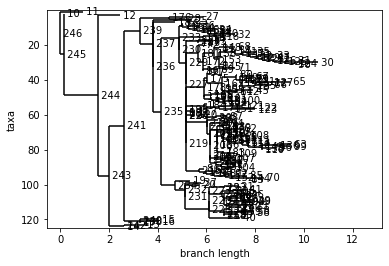

total branch length of the tree 85.24189853792228


AttributeError: 'Tree' object has no attribute 'write'

In [32]:
Phylo.draw(TREE)
print('total branch length of the tree',TREE.total_branch_length())
get_distance_matrix_from_phylogeny(TREE)


In [33]:
distmat = get_distance_matrix_from_phylogeny(TREE)
# distmat.to_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run2/arrays_in_whole_dataset_v6_nonegv2_pairwiseDist.csv',header=True,sep='\t')
distmat.to_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_nonegv2_pairwiseDist.csv',header=True,sep='\t')


In [38]:
Phylo.write(TREE,'/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_noneg.nwk','newick')


1

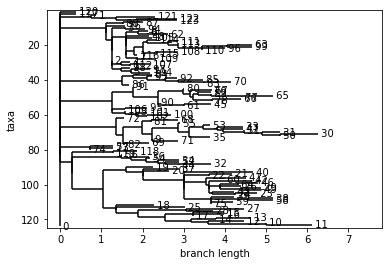

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,NaN,0.862,1.24861,1.57829,1.70459,1.70936,2.12626,1.86331,2.12626,2.22228,...,2.34204,2.35346,1.85487,0.39209,1.85384,1.28805,0.39209,2.29923,2.84501,2.84501
1,0.862,NaN,2.11061,2.44029,2.56659,2.57136,2.98826,2.72531,2.98826,3.08428,...,3.20404,3.21546,2.71687,1.25409,2.71584,2.15005,1.25409,1.64329,2.18907,2.18907
2,1.24861,2.11061,NaN,0.33076,0.45598,0.46183,0.87873,0.61578,0.87873,3.47089,...,1.09451,1.10593,0.60734,1.6407,3.10245,2.53666,1.6407,3.54784,4.09362,4.09362
3,1.57829,2.44029,0.33076,NaN,0.78674,0.79151,1.20841,0.94546,1.20841,3.80057,...,1.42419,1.43561,0.93702,1.97038,3.43213,2.86634,1.97038,3.87752,4.4233,4.4233
4,1.70459,2.56659,0.45598,0.78674,NaN,0.91781,1.33471,1.07176,1.33471,3.92687,...,1.55049,1.56191,1.06332,2.09668,3.55843,2.99264,2.09668,4.00382,4.5496,4.5496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1.28805,2.15005,2.53666,2.86634,2.99264,2.99741,3.41431,3.15136,3.41431,3.51033,...,3.63009,3.64151,3.14292,1.68014,0.56579,NaN,1.68014,3.58728,4.13306,4.13306
120,0.39209,1.25409,1.6407,1.97038,2.09668,2.10145,2.51835,2.2554,2.51835,2.61437,...,2.73413,2.74555,2.24696,0.78418,2.24593,1.68014,NaN,2.69132,3.2371,3.2371
121,2.29923,1.64329,3.54784,3.87752,4.00382,4.00859,4.42549,4.16254,4.42549,4.52151,...,4.64127,4.65269,4.1541,2.69132,4.15307,3.58728,2.69132,NaN,2.43938,2.43938
122,2.84501,2.18907,4.09362,4.4233,4.5496,4.55437,4.97127,4.70832,4.97127,5.06729,...,5.18705,5.19847,4.69988,3.2371,4.69885,4.13306,3.2371,2.43938,NaN,2.00572


In [30]:
# Trees = [tree for tree in Phylo.parse('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2 (2020-12-13, 13:14).nwk', 'newick')]
Trees = [tree for tree in Phylo.parse('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_0rootunrooted.nwk', 'newick')]

tree = Trees[0]
Phylo.draw(tree)
get_distance_matrix_from_phylogeny(tree)

In [24]:
tree.rooted=False
# Phylo.draw(tree)
import networkx
from networkx.drawing import nx_agraph
networkx.graphviz_layout = nx_agraph.graphviz_layout
Phylo.draw_graphviz(tree, prog="neato", node_size=0)


AttributeError: 'Graph' object has no attribute 'node'

In [80]:
a=-1
b=-2
if ((a<0 or b<0) and (a+b<0)):
    print(a,b)

-1 -2


In [89]:
# does rerouting the tree before geting the distance matrix do the trick?

Trees = [tree for tree in Phylo.parse('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run2/arrays_in_whole_dataset_v6.nwk', 'newick')]

Tree= Trees[0]

In [139]:
df=pd.read_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/ALLCRISPRs_haplo_matches_at_5_dist_V6_sorted.txt')

df=pd.DataFrame([v.split('_') for v in df['seq.id'].values], columns=df['seq.id'][0].split('_'))
df[df!='NA']=1
df[df=='NA']=0
df=df.reindex()
df.to_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Spacers_PresenceAbsence.txt',header=True,sep='\t')
df

,flk,sp5,sp170,sp51,sp22,sp79,sp161,sp174,sp179,sp37,sp47,sp440,sp184,sp55,sp58,sp295,tailprimer
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1
2,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1
4,1,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1
120,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
121,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1
122,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1


In [39]:
def Get_noneg_phylogeny_and_pairwiseDist_from_ancestorsDist(df):
    # init terminal clades 
    clades = dict(zip(df.index,(BaseTree.Clade(None, str(name)) for name in df.index)))
    inner_count = len(df)-1

    while len(df.columns)>1:
        inner_count+=1

        # find minimum distance pair
        max_pair=get_weights_for_all_pairs(df)
        min_i=max_pair[0]
        min_j=max_pair[1]

        # calculate nodeDist
        df=get_new_node_distance(df,max_pair)

        # create clade 
        clade1 = clades[min_i] 
        clade2 = clades[min_j] 
        inner_clade = BaseTree.Clade(None, str(inner_count)) 
        inner_clade.clades.append(clade1) 
        inner_clade.clades.append(clade2) 
        # assign branch length 
        clade1.branch_length = float(df.loc[min_i, min_j])
        clade2.branch_length = float(df.loc[min_j, min_i])
    #     if ((clade1.branch_length<0 or clade2.branch_length<0) and (clade2.branch_length+clade1.branch_length<0)):
    #         print('clade2.branch_length,clade1.branch_length',clade2.branch_length,clade1.branch_length)
    #          break

        if clade1.branch_length<0:
            clade2.branch_length = clade2.branch_length+clade1.branch_length
            clade1.branch_length = 0
        if clade2.branch_length<0:
            clade1.branch_length = clade1.branch_length+clade2.branch_length
            clade2.branch_length = 0

        # update node dict 
        clades[inner_count] = inner_clade
        del clades[min_i]
        del clades[min_j]
        if len(clades)==1:
            inner_clade.branch_length = None

        # rebuild distance matrix
        df=df.drop([min_i,min_j],axis=1).drop([min_i,min_j],axis=0)



    TREE=Tree(inner_clade,rooted=True)
    noneg_dist = get_distance_matrix_from_phylogeny(TREE)

    return(TREE,noneg_dist)

################
df=pd.read_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_ancestorsDist.csv',sep='\t',index_col=0)

df.columns=list(map(int,df.columns))
df.index=list(map(int,df.columns))


TREE,noneg_dist = Get_noneg_phylogeny_and_pairwiseDist_from_ancestorsDist(df)

Phylo.write(TREE,'/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_noneg.nwk','newick')

noneg_dist.to_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_noneg_pairwiseDist.csv',header=True,sep='\t')

In [42]:
noneg_dist.to_csv('/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_noneg_pairwiseDist.csv',header=True,sep='\t')

In [41]:
Phylo.write(TREE,'/Users/maeperez/Desktop/CRISPR_distance/Mydata/Runs_on_cluster/run4/arrays_in_whole_dataset_v6.2_noneg.nwk','newick')


1